# Pattern exploration
---

In [656]:
from IPython.display import SVG
import numpy as np
import pickle
from scipy import sparse

from sknetwork.data import load_netset
from sknetwork.topology import get_connected_components
from sknetwork.utils import get_degrees
from sknetwork.visualization import svg_graph

In [658]:
def load_data(dataset: str):
    """Load data and return loaded elements as a tuple.
    
    Parameters
    ----------
    dataset: str
        Name of dataset (on netset or local).
    """
    netset = ['wikivitals-fr', 'wikischools', 'wikivitals', 'wikihumans']
    labels = ''

    if dataset in netset:
        graph = load_netset(dataset)
        if dataset != 'wikihumans':
            labels = graph.labels

    elif dataset == 'lastfm':
        with open(f'/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/notebooks/data/{dataset}', 'br') as f:
            graph = pickle.load(f)

    adjacency = graph.adjacency
    biadjacency = graph.biadjacency
    names = graph.names
    names_col = graph.names_col
    
    return adjacency, biadjacency, names, names_col, labels

In [659]:
def preprocess_data(biadjacency, names_col, s):
    # Frequent attributes
    freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
    index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= s))

    # Filter data with index
    biadjacency = biadjacency[:, index]
    words = names_col[index]
    freq_attribute = freq_attribute[index]
    
    # Sort data
    sort_index = np.argsort(freq_attribute)
    sorted_biadjacency = biadjacency[:, sort_index]
    words = words[sort_index]
    return sorted_biadjacency, words

def get_pattern(patterns, i):
    return patterns[i][0], patterns[i][1]

def display_pattern(adjacency, nodes, names, labels):
    if labels=='':
        return SVG(svg_graph(adjacency[nodes, :][:, nodes] + sparse.identity(len(nodes)), names=names[nodes], edge_width_max=1))
    else:
        return SVG(svg_graph(adjacency[nodes, :][:, nodes] + sparse.identity(len(nodes)), names=names[nodes], labels=labels[nodes], edge_width_max=1))

## Parameters  

Select:
- dataset: either `wikivitals`, `wikivitals-fr` or `wikischools`
- $s$ and $\beta$: support parameters (here 5)
- order_attributes: initial ordering of attributes (here True)

In [1091]:
# Parameters for UnexPatterns
dataset = 'wikischools'
s = 4
beta = 4
order_attributes = True

**Load graph data and preprocess it (e.g attribute ordering)**

In [1092]:
# Load data
adjacency, biadjacency, names, names_col, labels = load_data(dataset)

# Preprocess data (get same attribute order as in UnexPattern)
new_biadjacency, words = preprocess_data(biadjacency, names_col, s)

Parsing files...
Done.


**Load `UnexPatterns` output**

Output of algorithm is a list of patterns, i.e. a list of tuples (nodes, attributes).

In [1093]:
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG'

with open(f'{inpath}/result_{dataset}_{beta}_{s}_order{str(order_attributes)}_prob.bin', 'rb') as data:
    res = pickle.load(data)

In [1094]:
print(f'Number of patterns found: {len(res)}')

Number of patterns found: 2463


In [1095]:
# First pattern (pattern of index 0 is the starting point of lattice)
idx = 1 #np.random.choice(len(res))
print(res[idx])

nodes = res[idx][0]
attributes = res[idx][1]
print(names[nodes], words[attributes])

([518, 567, 2354, 2865], [1, 1992, 7496, 9907, 10123, 10125, 10168, 10203, 10238, 10256, 10261, 10288, 10329])
['Bolivia' 'Peru' 'Bogotá' 'Simón Bolívar'] ['simón' 'bolívar' 'colombia' 'spanish' 'presid' 'latin' 'de' 'listen'
 'territori' 'empir' 'america' 'independ' 'polit']


**Display pattern**

Pattern index: 1173
Attributes: ['chester' 'german' 'ii' 'war' 'becam']


/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/3453224079.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


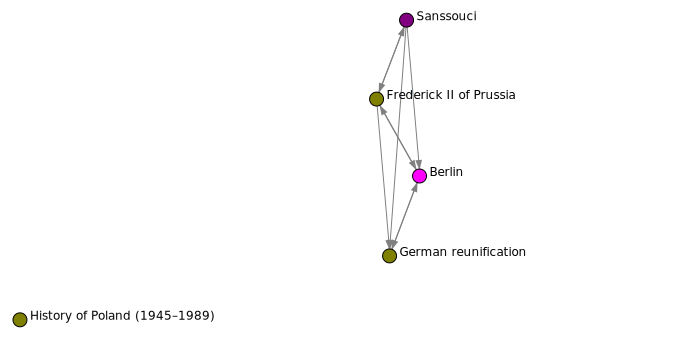

In [1104]:
# Random pattern
idx = np.random.choice(len(res))
nodes, attributes = get_pattern(res, idx)

print(f'Pattern index: {idx}')
print(f'Attributes: {words[attributes]}')

# Display pattern
display_pattern(adjacency, nodes, names, labels)

## Patterns from keywords

Select pattern related to specific keywords, i.e. patterns that contain **at least one** keyword in list.

In [1105]:
def get_patterns(patterns, keyword, words):
    res = []
    for p in patterns:
        for w in keywords:
            index = np.argwhere(words==w)
            if len(index) > 0:
                if int(index) in p[1]:
                    res.append(p)
                    break
            else:
                raise Exception(f'keyword: {w} is not found.')
    return res

In [1106]:
valid_words = np.unique(np.asarray([words[w] for p in res for w in p[1]]))
print(len(valid_words))

2471


In [1107]:
# Select keywords
#print(f'Some random words to get inspiration: {np.random.choice(words, 15)}')
print(f'Some random words to get inspiration: {np.random.choice(valid_words, 15)}')

Some random words to get inspiration: ['gottlieb' 'snow' 'inland' 'compani' 'becom' 'commonwealth' 'older'
 'inact' 'zone' 'mudflat' 'plan' 'extend' 'cataract' 'geolog' 'often']


In [1108]:
# Chose keywords
keywords = ['snow', 'commonwealth']

In [1109]:
kw_patterns = get_patterns(res, keywords, words)
print(f'Number of patterns related to {keywords}: {len(kw_patterns)}')

Number of patterns related to ['snow', 'commonwealth']: 5


Attributes of patter: ['toughest' 'snow' 'retir' 'asia' 'empir' 'central' 'europ' 'led'
 'histori' 'power']


/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/3453224079.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


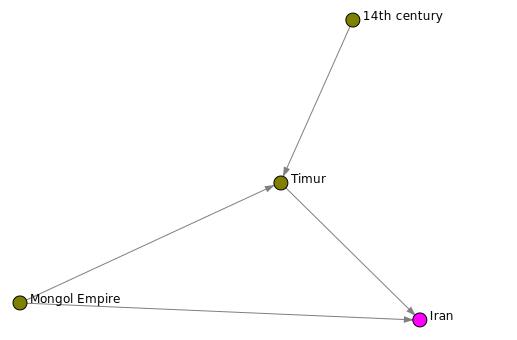

In [1110]:
first_pattern = get_pattern(kw_patterns, 0)

print(f'Attributes of patter: {words[first_pattern[1]]}')
display_pattern(adjacency, first_pattern[0], names, labels)

Attributes of pattern 3/4: ['hindustani' 'sun' 'commonwealth' 'tropic' 'rank']


/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/3453224079.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


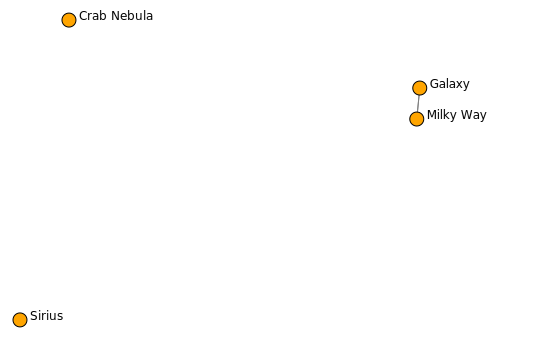

In [1111]:
idx = np.random.choice(len(kw_patterns))
rand_pattern = get_pattern(kw_patterns, idx)

print(f'Attributes of pattern {idx}/{len(kw_patterns)-1}: {words[rand_pattern[1]]}')
display_pattern(adjacency, rand_pattern[0], names, labels)

## Pattern summaries from keywords 

In [1112]:
def get_summarized_graph(adjacency, patterns):
    """Get summarized graph given patterns and original adjacency matrix."""
    
    rows, cols = [], []

    for p in patterns:

        # exclude first element of lattice 
        if len(p[1]) > 0:
            nodes = sorted(p[0])
            idx = 0
            idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from concepts
            # reindex nodes
            for n in nodes:
                if n not in idx_nodes:
                    idx_nodes[idx] = n
                    idx += 1
            
            # Record edges from subgraph related to concept
            adj_pattern = adjacency[nodes, :][:, nodes].tocoo()
            reindex_rows = [int(idx_nodes[src]) for src in adj_pattern.row]
            reindex_cols = [int(idx_nodes[dst]) for dst in adj_pattern.col]
            rows += reindex_rows
            cols += reindex_cols
            
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

def get_summarized_biadjacency(adjacency, biadjacency, patterns):
    summarized_biadj = np.zeros((adjacency.shape[0], biadjacency.shape[1]))
    for p in patterns:
        if len(p[1]) > 0:
            for node in p[0]:
                summarized_biadj[node, p[1]] += 1

    summarized_biadj = sparse.csr_matrix(summarized_biadj.astype(bool), shape=summarized_biadj.shape)
    return summarized_biadj

In [1220]:
def display_pattern_summary(summarized_adjacency, summarized_biadjacency, mask, labels_cc, idx, names, names_col, labels, width=500, height=500):
    mask_cc = labels_cc == idx
    g = summarized_adjacency[mask, :][:, mask]
    g_cc = g[mask_cc, :][:, mask_cc]
    
    attributes = np.unique(summarized_biadj[mask, :][mask_cc, :].indices)
    print(f'Attributes: {names_col[attributes]}')
    
    if labels=='':
        return SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask][mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=width, height=height))
    else:
        return SVG(svg_graph(g_cc + sparse.identity(g_cc.shape[0]), names=names[mask][mask_cc], 
              edge_width_min=0.5, edge_width_max=0.5, width=width, height=height, labels=labels[mask][mask_cc]))

**Summarized graph**

In [1114]:
# Build summarized adjacency matrix, i.e. adjacency matrix of the union of all patterns found with UnexPatterns
summarized_adj = get_summarized_graph(adjacency, res)
summarized_adj

<4403x4403 sparse matrix of type '<class 'numpy.float64'>'
	with 2390 stored elements in Compressed Sparse Row format>

In [1115]:
# Build summarized biadjacency matrix
summarized_biadj = get_summarized_biadjacency(adjacency, new_biadjacency, res)
summarized_biadj

<4403x10383 sparse matrix of type '<class 'numpy.bool_'>'
	with 26182 stored elements in Compressed Sparse Row format>

**Pattern summaries**

In [1116]:
# Summarized graph filtered on used nodes
mask = np.flatnonzero(summarized_adj.astype(bool).dot(np.ones(summarized_adj.shape[1])))

# Number of connected components (NOT considering isolated nodes)
labels_cc_summarized = get_connected_components(summarized_adj[mask, :][:, mask])
nb_cc = len(np.unique(labels_cc_summarized)) 

print(f'Number of pattern summaries: {nb_cc}')

Number of pattern summaries: 135


In [1225]:
# Biggest pattern summaries (index of pattern, nb nodes)
sorted(dict(Counter(labels_cc_summarized)).items(), key=lambda x: x[1], reverse=True)[:10]

[(2, 228),
 (11, 111),
 (1, 58),
 (75, 33),
 (15, 25),
 (17, 25),
 (30, 20),
 (35, 17),
 (55, 17),
 (0, 15)]

Pattern summary: 1
Attributes: ['succumb' 'romulu' 'lepidu' 'soter' 'fife' 'corvu' 'barrist' 'horac'
 'sewn' 'reconquest' 'theoriz' 'brexit' 'existenti' 'irrepar' 'cadillac'
 'distinctli' 'unparallel' 'delight' 'her' 'hernán' 'brambl' 'hemoglobin'
 'phenotyp' 'eland' 'sevastopol' 'eratosthen' 'welbi' 'repositori'
 'escarp' 'heath' 'triumvir' 'paramagnet' 'fédération' 'untreat' 'akin'
 'محمد' 'thicken' 'yugoslav' 'mlb' 'władysław' 'palat' 'grung' 'germania'
 'gravel' 'fixtur' 'octavia' 'actium' 'ra' 'allah' 'sunda' 'transvaal'
 'ftse' 'harem' 'electrifi' 'octavian' 'quadruped' 'leftist' 'wrong' 'fa'
 'inact' 'isabella' 'stalk' 'shrine' 'titular' 'reveng' 'marcu' 'unix'
 'devil' 'gnu' 'transactinid' 'replic' 'burrow' 'antoni' 'fluoresc' 'noth'
 'northward' 'tribal' 'thinker' 'berber' 'ancestri' 'caesar' 'slavic'
 'suspect' 'client' 'disintegr' 'iberian' 'normandi' 'imagin' 'shark'
 'buddhist' 'beneath' 'feudal' 'juliu' 'frontier' 'lanka' 'suicid' 'boom'
 'chairman' 'physiolog' 'eldest' '

/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/706547866.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


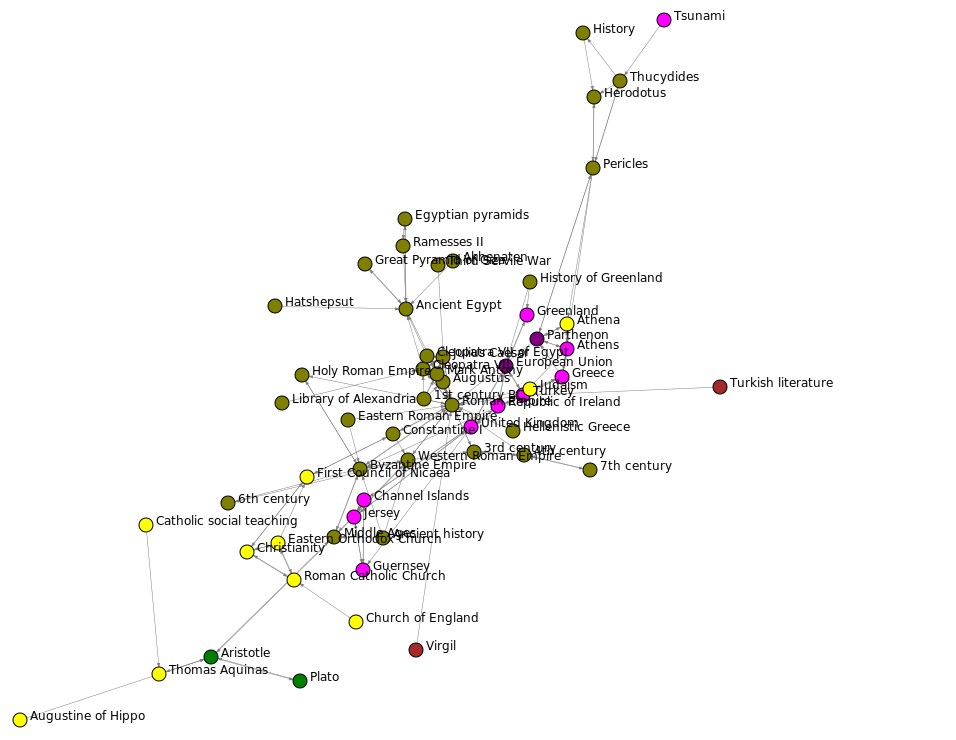

In [1236]:
# Display random pattern summary
idx = 1
print(f'Pattern summary: {idx}')
display_pattern_summary(summarized_adj, summarized_biadj, mask, labels_cc_summarized, idx, names, words, labels, width=700, height=700)

Pattern summary: 95
Attributes: ['suðreyjar' 'tycoon' 'regia' 'jurisprud' 'sure' 'decolon' 'croft' 'osama'
 'decod' 'steril' 'southampton' 'coldest' 'quartz' 'hebrid' 'maker'
 'papua' 'fring' 'azerbaijan' 'logic' 'nors' 'smith' 'lincoln' 'toler'
 'gaelic' 'want' 'similarli' 'prehistor' 'adjac' 'guinea' 'inner' 'rival'
 'stretch' 'outer' 'prepar' 'archipelago' 'tour' 'poet' 'scottish'
 'parliamentari' 'tourism' 'speed' 'basin' 'mainland' 'hard' 'rapidli'
 'ga' 'test' 'scotland' 'face' 'fish' 'declin' 'varieti' 'coast' 'other'
 'servic' 'island' 'languag' 'kingdom' 'western' 'west' 'east' 'refer'
 'major']


/var/folders/hb/p2nvp7cj1dg6y96zlm9vqb2c0000gn/T/ipykernel_22700/4041998973.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labels=='':


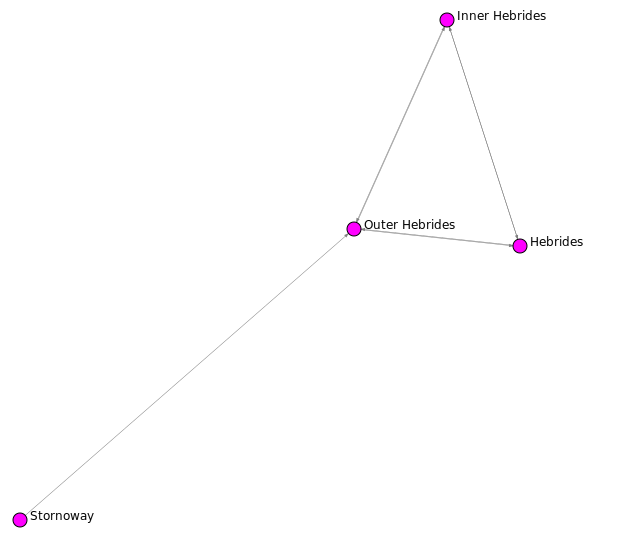

In [1047]:
# Display random pattern summary
idx = np.random.choice(nb_cc)
print(f'Pattern summary: {idx}')
display_pattern_summary(summarized_adj, summarized_biadj, mask, labels_cc_summarized, idx, names, words, labels)

In [527]:
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG'

with open(f'{inpath}/output/result/wasserstein_distances_{dataset}_{beta}_{s}_summaries.pkl', 'rb') as data:
    pw_distances = np.load(data)

In [530]:
pw_distances[pw_distances > 0.02]

1668

In [534]:
diversity(pw_distances, delta=0.2)

0.0

In [536]:
np.max(pw_distances)

0.17378258472657765

## Sias-Miner exploration

In [259]:
import json

inpath = '/Users/simondelarue/Downloads/Mining_Subjectively_Interesting_Attributed_Subgraphs/siasminer/Executable'

with open(f'{inpath}/resultsLastfm/results.json', 'rb') as f:
    data = json.load(f)

In [261]:
data.keys()

dict_keys(['numberOfPatterns', 'patterns'])

In [265]:
# Number of patterns with SIAS Miner (minVertices=100, maxDistance=1)
len(data.get('patterns'))

1184

In [457]:
def get_sias_pattern(pattern: dict):
    
    # get subgraph
    subgraph_nodes = np.asarray(list(map(int, pattern.get('subgraph'))))
    
    # get attributes
    pos_attrs = set(pattern.get('characteristic').get('positiveAttributes'))
    neg_attrs = set(pattern.get('characteristic').get('negativeAttributes'))
    attrs = np.asarray([int(x.split('>=')[0]) for x in pos_attrs.union(neg_attrs)])
    
    return subgraph_nodes, attrs

In [458]:
# List of all sias patterns
nb_sias_patterns = len(data.get('patterns'))

sias_patterns = [get_sias_pattern(data.get('patterns')[idx]) for idx in range(nb_sias_patterns)]

In [463]:
sias_patterns[5]

(array([ 796, 1466, 1059, 1157,  237, 1121,  772, 1502, 1688, 1772, 1702,
         514,  625,  708, 1032, 1394,  394, 1139, 1089,  793,  279, 1087,
         417, 1777,  371, 1365,  607, 1540,  693, 1019, 1605,  205,  703,
         296,  278,  741,   67,  615,  752,  220, 1058, 1100, 1122, 1712,
          36,  114,  459,  778, 1178, 1242, 1263, 1735, 1128,  103,  671,
         676,  572,  761, 1120, 1230,  822, 1154, 1622, 1803,  340,  396,
        1151,   19,  813,  428,  743,  422,  151, 1054,  200, 1653, 1685,
         343, 1260,  287, 1324, 1381,  288, 1699, 1576, 1736,  122, 1841,
         596, 1543, 1816, 1164,   56, 1696, 1443, 1000,  236,  857,  970,
         505,  936, 1249,  846]),
 array([45, 41, 13, 24]))

Attributes: ['jim morrison' 'amy winehouse' 'tags']


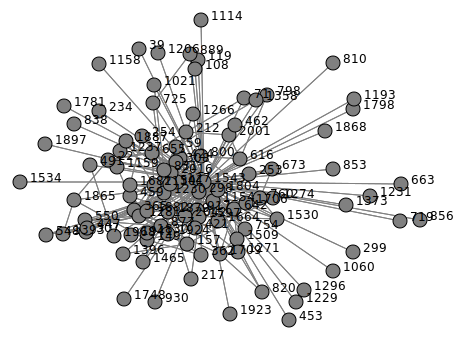

In [472]:
# Display pattern
idx = np.random.choice(len(data.get('patterns')))

node_idx, attr_idx = get_sias_pattern(data.get('patterns')[idx])

print(f'Attributes: {words[attr_idx]}')

display_pattern(adjacency, node_idx, names, labels)

**Patterns x attributes matrix**

In [473]:
nb_sias_patterns = len(data.get('patterns'))

sias_patterns_attributes = np.zeros((nb_sias_patterns, biadjacency.shape[1]))
for i, p in enumerate(sias_patterns):
    sias_patterns_attributes[i, p[1]] = 1

In [474]:
sias_patterns_attributes.shape

(1184, 9749)

**Doc2Vec model**

In [480]:
import gensim

class MyCorpus():
    """A memory-friendly iterator that yields documents as TaggedDocument objects, i.e tokens associated with index of document."""
    
    def __init__(self, data, vocab, tokens_only=False):
        self.data = data
        self.vocab = vocab
        self.tokens_only = tokens_only
    
    def __iter__(self):
        if isinstance(self.data, sparse.csr_matrix):
            for i, x in enumerate(self.data):
                tokens = list(self.vocab[x.indices])
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
        else:
            if not self.tokens_only:
                for i, x in enumerate(self.data):
                    tokens = list(self.vocab[np.flatnonzero(x)])
                    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            else:
                for i, x in enumerate(self.data):
                    tokens = list(self.vocab[np.flatnonzero(x)])
                    yield tokens

In [481]:
import numpy as np
from scipy.stats import wasserstein_distance
from tqdm import tqdm


def d2v_embedding(model, doc):
    """Use pre-trained model to embed document."""
    return model.infer_vector(doc)

def pairwise_wd_distance(matrix, n, model, names):
    """Doc2Vec embedding + pairwise Wasserstein distances between elements in matrix."""

    wd_matrix = np.zeros((n, n))
    
    for i in tqdm(range(n)):
        w1 = d2v_embedding(model, names[np.flatnonzero(matrix[i, :])])
        for j in range(n):
            w2 = d2v_embedding(model, names[np.flatnonzero(matrix[j, :])])
            wd_matrix[i, j] = wasserstein_distance(w1, w2)
            
    return wd_matrix

In [492]:
corpus = list(MyCorpus(biadjacency, names_col))
model = gensim.models.doc2vec.Doc2Vec(vector_size=15, min_count=5, epochs=300)
model.build_vocab(corpus)

# Training model
model.train(corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [497]:
w1 = model.infer_vector(names_col[np.flatnonzero(sias_patterns_attributes[10, :])])
w2 = model.infer_vector(names_col[np.flatnonzero(sias_patterns_attributes[12, :])])
print(names_col[np.flatnonzero(sias_patterns_attributes[10, :])])
print(names_col[np.flatnonzero(sias_patterns_attributes[12, :])])

['pop' '80s' 'synth-pop' 'field recording']
['ambient' '80s']


In [498]:
wasserstein_distance(w1, w2)

0.25575899295508864

**Pairwise distances**

In [499]:
d2v_wd_matrix_sias = pairwise_wd_distance(sias_patterns_attributes, nb_sias_patterns, model, names_col)

100%|████████████████████████████████████████████████████████████████| 1184/1184 [19:35:14<00:00, 59.56s/it]


In [500]:
# Save result
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result'

with open(f'{inpath}/wasserstein_distances_{dataset}_{beta}_{s}_sias_patterns.pkl', 'wb') as f:
    np.save(f, d2v_wd_matrix_sias)

In [501]:
def diversity(pw_distances: np.ndarray, delta: float=0.2) -> float:
    """Diversity, i.e. ratio between number of pairwise distances above threshold and total number of distances. 
    
    Parameters
    ----------
    pw_distances: np.ndarray
        Pairwise distances.
    delta: float (default=0.2)
        Minimumm pairwise distance threshold.
        
    Outputs
    -------
        Diversity. 
    """
    n = pw_distances.shape[0]
    upper = pw_distances[np.triu_indices(n)]
    nb_ps = np.sum(upper > delta)
    
    return nb_ps / len(upper)

In [503]:
div = diversity(d2v_wd_matrix_sias, delta=0.2)
print(f'Sias-patterns diversity: {div}')

Sias-patterns diversity: 0.8986258410309044


In [505]:
def get_community_graph(adjacency: sparse.csr_matrix, labels_communities: np.ndarray) -> sparse.csr_matrix:
    """Equivalent of summarized graph but for community-based methods. Returns the adjacency matrix of the graph made of the union of all communities. 
    
    Parameters
    ----------
    adjacency: sparse.csr_matrix
        Adjacency matrix of the graph
    labels_communities: np.ndarray
        Array of node community labels 

    Output
    ------
        Sparse matrix of the community graph.
    """
    n_com = len(np.unique(labels_communities))
    rows, cols = [], []
    for n in range(n_com):
        nodes = np.flatnonzero(labels_communities == n)
        idx = 0
        idx_nodes = np.array([-1] * len(nodes)) # number of unique nodes from communities
        # reindex nodes
        for n in nodes:
            if n not in idx_nodes:
                idx_nodes[idx] = n
                idx += 1

        # Record edges from subgraph related to community
        adj_com = adjacency[nodes, :][:, nodes].tocoo()
        reindex_rows = [int(idx_nodes[src]) for src in adj_com.row]
        reindex_cols = [int(idx_nodes[dst]) for dst in adj_com.col]
        rows += reindex_rows
        cols += reindex_cols
        
    return sparse.coo_matrix((np.ones(len(rows)), (rows, cols)), shape=adjacency.shape).tocsr()

def coverage(summarized_adjacency: sparse.csr_matrix) -> float:
    """Node coverage of summarized graph, i.e. ratio between number of nodes in summarized graph and number of nodes in original graph.
    
    Parameters
    ----------
    summarized_adjacency: sparse.csr_matrix
        Adjacency matrix of the summarized graph
    
    Outputs
    -------
        Node coverage. 
    """
    # number of nodes in summarized graph
    n_nodes = len(np.flatnonzero(summarized_adjacency.dot(np.ones(summarized_adjacency.shape[1]))))
    
    # Coverage
    cov = n_nodes / summarized_adjacency.shape[0]
    
    return cov

In [506]:
# Coverage
all_nodes_sias = set()
for i in range(nb_sias_patterns):
    nodes_idx, _ = get_sias_pattern(data.get('patterns')[i])
    all_nodes_sias |= set(nodes_idx)
    
cov = len(all_nodes_sias) / adjacency.shape[0]
print(f'Sias-pattern coverage: {cov}')

Sias-pattern coverage: 0.1559196617336152


In [507]:
# Conciseness

n_nodes, n_attrs = [], []
for i in range(nb_sias_patterns):
    nodes_idxs, attr_idxs = get_sias_pattern(data.get('patterns')[i])
    n_nodes.append(len(set(nodes_idxs)))
    n_attrs.append(len(set(attr_idxs)))
    
conc = np.median(n_nodes) + np.median(n_attrs)
print(f'Sias-pattern conciseness: {conc}')

Sias-pattern conciseness: 104.0


In [508]:
# Information
information = (div * cov) / np.sqrt(conc)
print(f'Sias-pattern information: {information*100}')

Sias-pattern information: 1.3739252888238092


In [1255]:
from sknetwork.clustering import Louvain

# Looking for resolutions
dataset = 'wikischools'
adjacency, biadjacency, names, names_col, labels = load_data(dataset)
inpath = '/Users/simondelarue/Documents/PhD/Research/Co-Meg/CoMEG/output/result/with_prob/'
filename = f'{inpath}/result_{dataset}_4_5_orderTrue_prob'

with open(f"{filename}.bin", "rb") as data:
    myres = pickle.load(data)
    
sumadj = get_summarized_graph(adjacency, myres)
mask = np.flatnonzero(sumadj.dot(np.ones(sumadj.shape[1])))
labels_cc_summarized = get_connected_components(sumadj[mask, :][:, mask])
print(len(np.unique(labels_cc_summarized)))

Parsing files...
Done.
79


In [1262]:
labels_pred = Louvain(4.59).fit_transform(adjacency)
print(len(np.unique(labels_pred)))

79
